In [20]:
import numpy as np
import torch

import matplotlib.pyplot as plt
import pandas as pd

from train import TrainerDAGMM
from preprocess import get_KDDCup99


def eval(model, dataloaders, device, n_gmm, sub = 30):
    """Testing the DAGMM model with added reconstruction loss"""
    dataloader_train, dataloader_test = dataloaders
    model.eval()
    print('Testing...')
    compute = ComputeLoss(model, None, None, device, n_gmm)
    with torch.no_grad():
        N_samples = 0
        gamma_sum = 0
        mu_sum = 0
        cov_sum = 0
        # Obtaining the parameters gamma, mu and cov using the training (clean) data.
        for x, _ in dataloader_train:
            x = x.float().to(device)

            _, _, z, gamma = model(x)
            phi_batch, mu_batch, cov_batch = compute.compute_params(z, gamma)

            batch_gamma_sum = torch.sum(gamma, dim=0)
            gamma_sum += batch_gamma_sum
            mu_sum += mu_batch * batch_gamma_sum.unsqueeze(-1)
            cov_sum += cov_batch * batch_gamma_sum.unsqueeze(-1).unsqueeze(-1)

            N_samples += x.size(0)

        train_phi = gamma_sum / N_samples
        train_mu = mu_sum / gamma_sum.unsqueeze(-1)
        train_cov = cov_sum / gamma_sum.unsqueeze(-1).unsqueeze(-1)

        # Obtaining Labels and energy scores for train data
        energy_train = []
        labels_train = []
        for x, y in dataloader_train:
            x = x.float().to(device)

            _, _, z, gamma = model(x)
            sample_energy, cov_diag  = compute.compute_energy(z, gamma, phi=train_phi,
                                                              mu=train_mu, cov=train_cov,
                                                              sample_mean=False)
            # Add reconstruction loss
            r = model.decode(model.encode(x))
            recon_loss = torch.norm(x - r, p=2, dim=1)
            sample_energy = sample_energy + recon_loss

            energy_train.append(sample_energy.detach().cpu())
            labels_train.append(y)
        energy_train = torch.cat(energy_train).numpy()
        labels_train = torch.cat(labels_train).numpy()

        # Obtaining Labels and energy scores for test data
        energy_test = []
        labels_test = []
        for x, y in dataloader_test:
            x = x.float().to(device)

            _, _, z, gamma = model(x)
            sample_energy, cov_diag  = compute.compute_energy(z, gamma, train_phi,
                                                              train_mu, train_cov,
                                                              sample_mean=False)
            # Add reconstruction loss
            r = model.decode(model.encode(x))
            recon_loss = torch.norm(x - r, p=2, dim=1)
            sample_energy = sample_energy + recon_loss

            energy_test.append(sample_energy.detach().cpu())
            labels_test.append(y)
        energy_test = torch.cat(energy_test).numpy()
        labels_test = torch.cat(labels_test).numpy()

        scores_total = np.concatenate((energy_train, energy_test), axis=0)
        labels_total = np.concatenate((labels_train, labels_test), axis=0)

    threshold = np.percentile(scores_total, 100 - sub)
    pred = (energy_test > threshold).astype(int)
    gt = labels_test.astype(int)
    precision, recall, f_score, _ = prf(gt, pred, average='binary')
    print("Precision : {:0.4f}, Recall : {:0.4f}, F-score : {:0.4f}".format(precision, recall, f_score))
    print('ROC AUC score: {:.2f}'.format(roc_auc_score(labels_total, scores_total)*100))
    return labels_total, scores_total


In [21]:
import numpy as np
import torch

import matplotlib.pyplot as plt
import pandas as pd

from train import TrainerDAGMM
# from test import eval
from preprocess import get_KDDCup99

In [22]:
class Args:
    num_epochs=200
    patience=50
    lr=1e-4
    lr_milestones=[50]
    batch_size=1024
    latent_dim=1
    n_gmm=4
    lambda_energy=0.1
    lambda_cov=0.005


args = Args()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = get_KDDCup99(args)

dagmm = TrainerDAGMM(args, data, device)
dagmm.train()

198371/198371: [===============================>] - ETA 0.0s
Training DAGMM... Epoch: 0, Loss: 41633791.732
198371/198371: [===============================>] - ETA 0.0s
Training DAGMM... Epoch: 1, Loss: 41566614.433
198371/198371: [===============================>] - ETA 0.0s
Training DAGMM... Epoch: 2, Loss: 41596714.887
198371/198371: [===============================>] - ETA 0.0s
Training DAGMM... Epoch: 3, Loss: 41650338.825
198371/198371: [===============================>] - ETA 0.0s
Training DAGMM... Epoch: 4, Loss: 41675119.557
198371/198371: [===============================>] - ETA 0.0s
Training DAGMM... Epoch: 5, Loss: 41640314.619
198371/198371: [===============================>] - ETA 0.0s
Training DAGMM... Epoch: 6, Loss: 41541884.062
198371/198371: [===============================>] - ETA 0.0s
Training DAGMM... Epoch: 7, Loss: 41656896.485
198371/198371: [===============================>] - ETA 0.0s
Training DAGMM... Epoch: 8, Loss: 41635662.835
198371/198371: [============

In [23]:
import torch
import numpy as np

from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_fscore_support as prf, accuracy_score

from forward_step import ComputeLoss

sub = [10,20,30, 40, 50, 60]
for s in sub:
    print(s)
    labels, scores = eval(dagmm.model, data, device, args.n_gmm, sub=s)

10
Testing...


Precision : 0.9464, Recall : 0.4557, F-score : 0.6152
ROC AUC score: 98.62
20
Testing...
Precision : 0.9505, Recall : 0.9200, F-score : 0.9350
ROC AUC score: 98.62
30
Testing...
Precision : 0.7919, Recall : 0.9995, F-score : 0.8837
ROC AUC score: 98.62
40
Testing...
Precision : 0.6590, Recall : 0.9996, F-score : 0.7943
ROC AUC score: 98.62
50
Testing...
Precision : 0.5952, Recall : 0.9999, F-score : 0.7462
ROC AUC score: 98.62
60
Testing...
Precision : 0.5952, Recall : 0.9999, F-score : 0.7462
ROC AUC score: 98.62


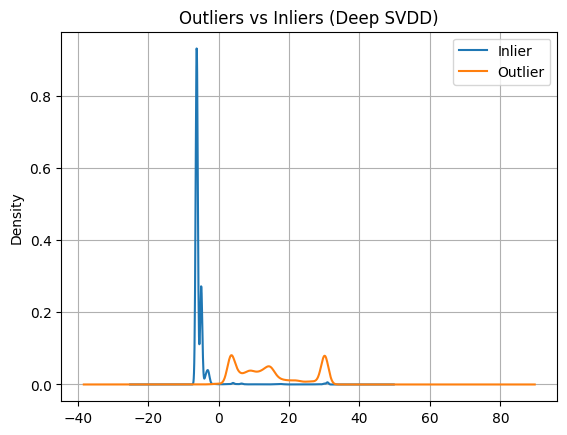

In [24]:
scores_in = scores[np.where(labels==0)[0]]
scores_out = scores[np.where(labels==1)[0]]


in_ = pd.DataFrame(scores_in, columns=['Inlier'])
out_ = pd.DataFrame(scores_out, columns=['Outlier'])


fig, ax = plt.subplots()
in_.plot.kde(ax=ax, legend=True, title='Outliers vs Inliers (Deep SVDD)')
out_.plot.kde(ax=ax, legend=True)
ax.grid(axis='x')
ax.grid(axis='y')
plt.show()